In [28]:
# imports
from refexps import move_level, gamerun_level, get_previous, load_data, extract_info

import pickle
from os import listdir

from collections import Counter
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.stats import norm

%matplotlib inline

In [29]:
#current: [((a_m, z_m), {speaker: {obj: {type: [(exp, (a_e, z_e), cat)]}}})]
#previously: {(start_i, end_i):{speaker:{obj_id:{ref_type:[refs_exp_ls]}}}}

#bigram construction
corpus = 'Push_to_Talk_Corpus'

# [PTT_data, FTT_data]
dataset = [[], []]
for name in listdir('Dataset/'+ corpus +'/RefExp/'):
    with open("Dataset/"+ corpus +"/RefExp/" + name) as handle:
        d = pickle.load(handle)
        condition = 0 if name.startswith('PTT') else 1
        dataset[condition].append(d)
        
move_lvl_dataset = [[move_level(d) for d in cond] for cond in dataset]

type_ref_exp_dict = {ref_type : [] for ref_type in ['comp_loc', 'part_of_piece', 'location', 'desc_piece', 'piece', 'comp_piece']}

type_ref_exp_dict = {ref_type :[ref[2] for ref in obj_ref_ls] 
                     for cond in move_lvl_dataset for game in cond for move_span, move_dict in game 
                     for (obj_id, ref_type), obj_ref_ls in move_dict.iteritems()}

from collections import defaultdict

type_ref_exp_dict = {ref_type : [] for ref_type in ['comp_loc', 'part_of_piece', 'location', 'desc_piece', 'piece', 'comp_piece']}

for cond in move_lvl_dataset:
    for game in cond:
        for move_span, move_dict in game:
            for (obj_id, ref_type), obj_ref_ls in move_dict.iteritems():
                type_ref_exp_dict[ref_type].extend([ref[2] for ref in obj_ref_ls])


#print type_ref_exp_dict.keys()
#print
                
#print [exp for exp in type_ref_exp_dict['location'] if len(exp)>10 and len(exp)<50]

#print move_lvl_dataset

C:\Program Files\Anaconda\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\Program Files\Anaconda\lib\site-packages\numpy\core\_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


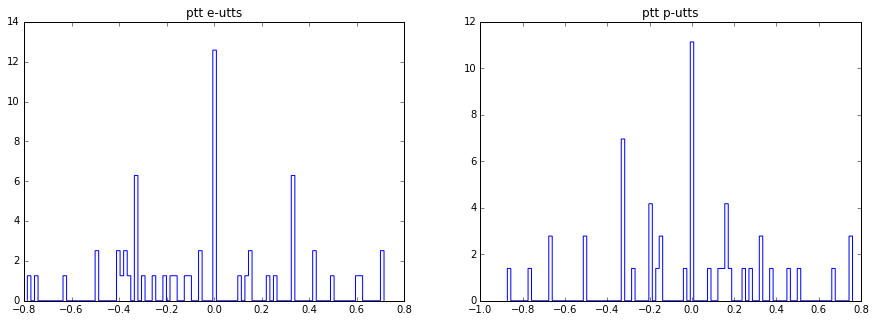

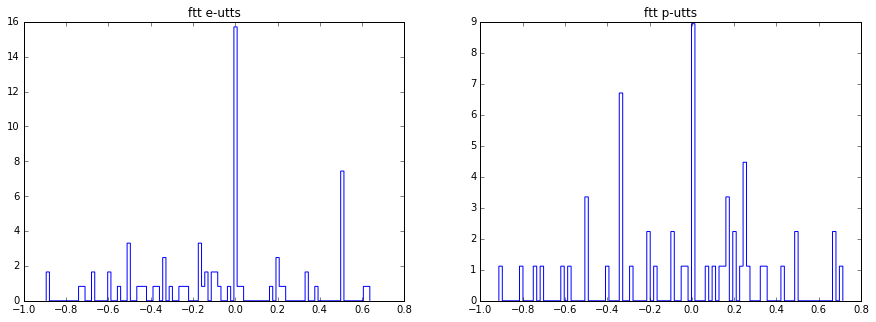

Significance of difference in conditions and speaker:
ptt e-utts, ptt p-utts:  Ttest_indResult(statistic=-0.080918330431504329, pvalue=0.93568656830172192)
ptt e-utts, ftt e-utts:  Ttest_indResult(statistic=0.62701552937693505, pvalue=0.53192323000756581)
ftt e-utts, ftt p-utts:  Ttest_indResult(statistic=-0.50263794763024938, pvalue=0.61619594872762362)
ptt p-utts, ftt p-utts:  Ttest_indResult(statistic=0.17634943314537657, pvalue=0.86040562480067262)
MOVE LEVEL:

ALIGNMENT:

PTT:
e-utts:  -0.0349565018803
	 variance:  0.129446213278
p-utts:  -0.028800330949
	 variance:  0.141841360402

FTT:
e-utts:  -0.0755021310357
	 variance:  0.131987223616
p-utts:  -0.0423968909562
	 variance:  0.142872663951

ALL:
e-utts:  -0.0592224466021
	 variance:  0.131362011388
p-utts:  -0.0363539753974
	 variance:  0.142459952853


In [30]:
# per-move alignment bigram construction
per_move_prevs = [{move_span: [(exp, get_previous(exp, ref_obj_exp_ls)) 
              for ref_obj_exp_ls in obj_dict.values() for exp in ref_obj_exp_ls] for d in cond 
                  for move_span, obj_dict in d} for cond in move_lvl_dataset]

get_exp_len = lambda exp_tup: exp_tup[0][1] - exp_tup[0][0] + 1

per_move_prevs_lens = [{move_span: [(exp[1], get_exp_len(exp), get_exp_len(prev_exp)) 
                                   for exp, prev_exp in exp_ls if not prev_exp == 'no_previous'] 
                      for move_span, exp_ls in cond.iteritems()} for cond in per_move_prevs]


# metric of coherence in length of expression and previous - construction

coh_metric = lambda e, prev_e: float(e - prev_e)/(e + prev_e)

per_move_coh_metrics = [{move_span: [(speaker, coh_metric(exp, prev_exp)) for speaker, exp, prev_exp in exp_ls] 
                      for move_span, exp_ls in cond.iteritems()} for cond in per_move_prevs_lens]

# (e-utts, p-utts)
move_speaker_metrics = [{move_span: ([m for s, m in exp_ls if s == 'e-utts'], [m for s, m in exp_ls if s == 'p-utts'])
                      for move_span, exp_ls in cond.iteritems()} for cond in per_move_coh_metrics]

move_speaker_metrics_avgs = [{move_span: (np.mean(e_metrics), np.mean(p_metrics))
                      for move_span, (e_metrics, p_metrics) in cond.iteritems()} for cond in move_speaker_metrics]


per_speaker_avgs = [list(zip(*cond.values())) for cond in move_speaker_metrics_avgs]

filter_nan = lambda ls : filter(lambda x: not np.isnan(x), ls)

per_speaker_avgs_filtered = [[filter_nan(speaker_ls) for speaker_ls in cond] for cond in per_speaker_avgs]

titles = ['ptt e-utts', 'ptt p-utts', 'ftt e-utts', 'ftt p-utts']
title_i = 0
for cond in per_speaker_avgs_filtered:
        fig = plt.figure(figsize=[15, 5])
        for speaker in cond:
            ax = fig.add_subplot(int(str(12)+str(title_i%2+1)))
            n, bins, patches = ax.hist(speaker, 100, histtype='step', normed=True)
            plt.title(titles[title_i])
            title_i += 1
        plt.show()

print 'Significance of difference in conditions and speaker:'
t_test_result = scipy.stats.ttest_ind(per_speaker_avgs_filtered[0][0], per_speaker_avgs_filtered[0][1], equal_var=False)
print 'ptt e-utts, ptt p-utts: ', t_test_result
t_test_result = scipy.stats.ttest_ind(per_speaker_avgs_filtered[0][0], per_speaker_avgs_filtered[1][0], equal_var=False)
print 'ptt e-utts, ftt e-utts: ', t_test_result
t_test_result = scipy.stats.ttest_ind(per_speaker_avgs_filtered[1][0], per_speaker_avgs_filtered[1][1], equal_var=False)
print 'ftt e-utts, ftt p-utts: ', t_test_result
t_test_result = scipy.stats.ttest_ind(per_speaker_avgs_filtered[0][1], per_speaker_avgs_filtered[1][1], equal_var=False)
print 'ptt p-utts, ftt p-utts: ', t_test_result




ptt_e_mean, ptt_p_mean, ftt_e_mean, ftt_p_mean = [np.mean(speaker_ls) for cond in per_speaker_avgs_filtered 
                                                                      for speaker_ls in cond]

ptt_e_var, ptt_p_var, ftt_e_var, ftt_p_var = [np.var(speaker_ls) for cond in per_speaker_avgs_filtered 
                                                                      for speaker_ls in cond]

print 'MOVE LEVEL:\n'
print 'ALIGNMENT:\n'
print 'PTT:'
print 'e-utts: ', ptt_e_mean
print '\t variance: ', ptt_e_var
print 'p-utts: ', ptt_p_mean
print '\t variance: ', ptt_p_var
print '\nFTT:'
print 'e-utts: ', ftt_e_mean
print '\t variance: ', ftt_e_var
print 'p-utts: ', ftt_p_mean
print '\t variance: ', ftt_p_var

print '\nALL:'
print 'e-utts: ', np.mean(per_speaker_avgs_filtered[0][0]+per_speaker_avgs_filtered[1][0])
print '\t variance: ', np.var(per_speaker_avgs_filtered[0][0]+per_speaker_avgs_filtered[1][0])
print 'p-utts: ', np.mean(per_speaker_avgs_filtered[0][1]+per_speaker_avgs_filtered[1][1])
print '\t variance: ', np.var(per_speaker_avgs_filtered[0][1]+per_speaker_avgs_filtered[1][1])
# scipy.stats.ttest_ind(data_same_gender[0], data_same_gender[1], equal_var=False)

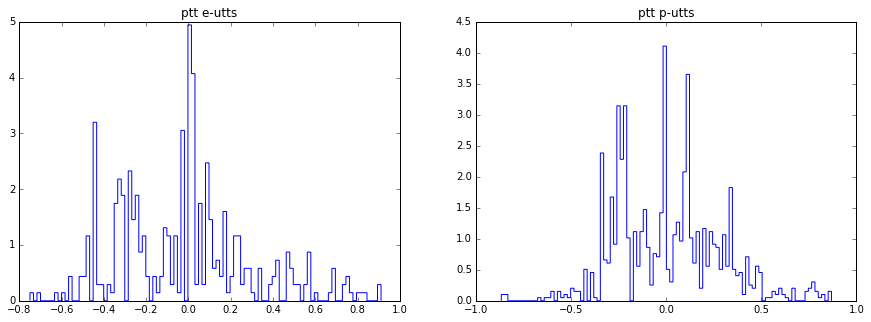

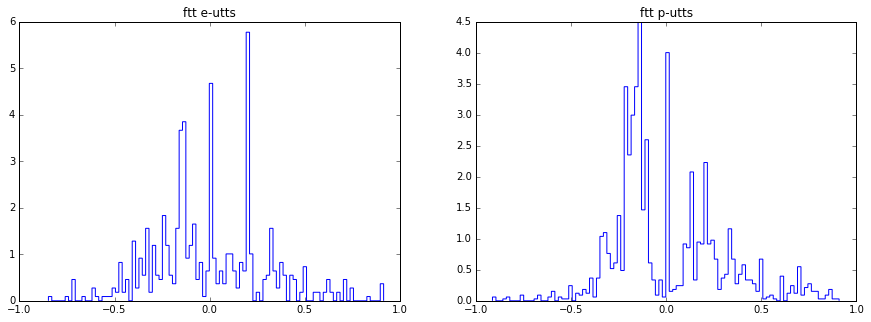

Significance of difference in conditions and speaker:
ptt e-utts, ptt p-utts:  Ttest_indResult(statistic=-0.66083621268621373, pvalue=0.51016226013844901)
ptt e-utts, ftt e-utts:  Ttest_indResult(statistic=0.29826593814038438, pvalue=0.76591815594383883)
ftt e-utts, ftt p-utts:  Ttest_indResult(statistic=-1.9871587626139682, pvalue=0.048745897536572227)
ptt p-utts, ftt p-utts:  Ttest_indResult(statistic=-1.3683148152805591, pvalue=0.1729102607809456)
MOVE LEVEL:

COHERENCE:

PTT:
e-utts:  -0.0105645091336
	 variance:  0.0639645073358
p-utts:  0.0133424036341
	 variance:  0.0246763326765

FTT:
e-utts:  -0.0238053414139
	 variance:  0.0848513027749
p-utts:  0.0498785754271
	 variance:  0.0411583111227

ALL:
e-utts:  -0.018093609842
	 variance:  0.0758843167877
p-utts:  0.0345889817963
	 variance:  0.034585812993


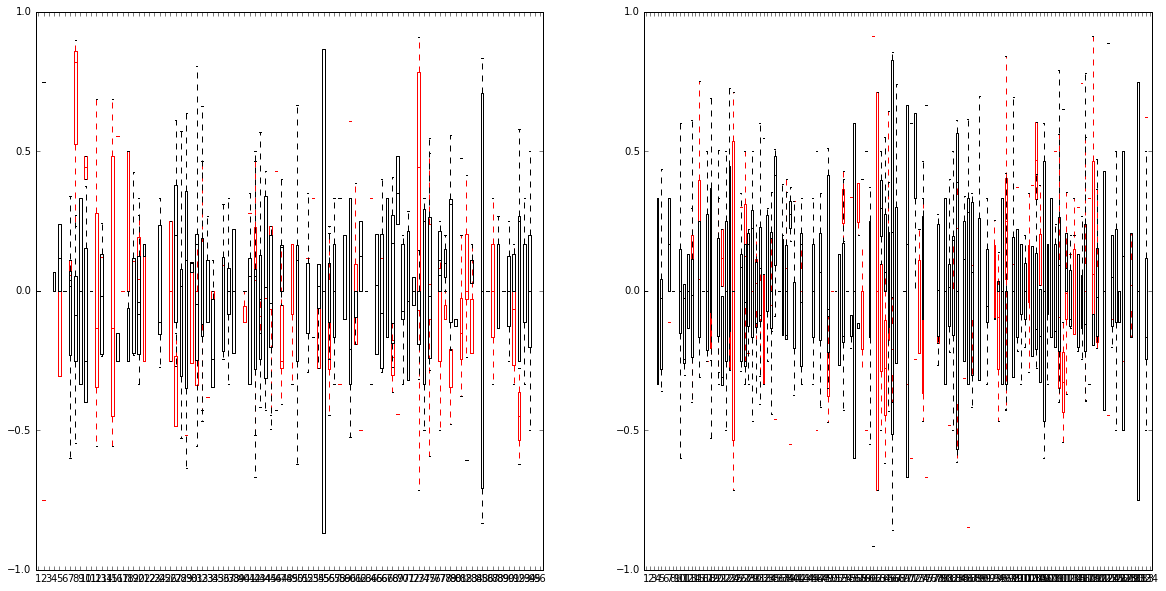

In [31]:
# per-move coherence construction

per_move_combs = [{move_span: [(exp, set(ref_obj_exp_ls) - {exp}) 
              for ref_obj_exp_ls in obj_dict.values() for exp in ref_obj_exp_ls] for d in cond 
                  for move_span, obj_dict in d} for cond in move_lvl_dataset]

get_exp_len = lambda exp_tup: exp_tup[0][1] - exp_tup[0][0] + 1

per_move_combs_lens = [{move_span: [(exp[1], get_exp_len(exp), [get_exp_len(e) for e in other_exp_ls]) 
                                   for exp, other_exp_ls in exp_ls] 
                      for move_span, exp_ls in cond.iteritems()} for cond in per_move_combs]

#print per_move_combs_lens


# metric of coherence in length of expression and previous - construction

coh_metric = lambda e, prev_e: float(e - prev_e)/(e + prev_e)

coh_metric_over_ls = lambda e, e_ls: [coh_metric(e, other_e) for other_e in e_ls]

per_move_comb_coh_metrics = [{move_span: [(speaker, coh_metric_over_ls(exp, other_exps)) for speaker, exp, other_exps in exp_ls] 
                      for move_span, exp_ls in cond.iteritems()} for cond in per_move_combs_lens]


# (e-utts, p-utts)
move_speaker_comb_metrics = [{move_span: ([m_ls for s, m_ls in exp_ls if s == 'e-utts'], [m_ls for s, m_ls in exp_ls if s == 'p-utts'])
                      for move_span, exp_ls in cond.iteritems()} for cond in per_move_comb_coh_metrics]


move_speaker_comb_metrics_avgs = [{move_span: ([np.mean(e_m) for e_m in e_metrics], [np.mean(p_m) for p_m in p_metrics])
                      for move_span, (e_metrics, p_metrics) in cond.iteritems()} for cond in move_speaker_comb_metrics]

filter_nan = lambda ls : filter(lambda x: not np.isnan(x), ls)
                    
move_speaker_comb_metrics_avgs = [{move_span: (e_metrics, 
                                               p_metrics)
                      for move_span, (e_metrics, p_metrics) in cond.iteritems()} for cond in move_speaker_comb_metrics_avgs]                    

replace_nan = lambda ls : map(lambda x: 0 if np.isnan(x) else x, ls)

move_speaker_comb_metrics_avgs = [{move_span: (filter_nan(e_metrics), 
                                               filter_nan(p_metrics))
                      for move_span, (e_metrics, p_metrics) in cond.iteritems()} for cond in move_speaker_comb_metrics_avgs]

per_speaker_comb_vals = [list(zip(*cond.values())) for cond in move_speaker_comb_metrics_avgs]


titles = ['ptt e-utts', 'ptt p-utts', 'ftt e-utts', 'ftt p-utts']
title_i = 0
for cond in per_speaker_comb_vals:
        fig = plt.figure(figsize=[15, 5])
        for speaker in cond:
            ax = fig.add_subplot(int(str(12)+str(title_i%2+1)))
            speaker_vals_merged = [val for move in speaker for val in move]
            n, bins, patches = ax.hist(speaker_vals_merged, 100, histtype='step', normed=True)
            plt.title(titles[title_i])
            title_i += 1
        plt.show()


move_speaker_comb_metrics_avg_avgs = [{move_span: (np.mean(e_metrics), 
                                               np.mean(p_metrics))
                      for move_span, (e_metrics, p_metrics) in cond.iteritems()} for cond in move_speaker_comb_metrics_avgs]


per_speaker_comb_avgs = [list(zip(*cond.values())) for cond in move_speaker_comb_metrics_avg_avgs]

#print per_speaker_comb_avgs

per_speaker_comb_avgs = [[filter_nan(ls) for ls in cond] for cond in per_speaker_comb_avgs]

print 'Significance of difference in conditions and speaker:'
t_test_result = scipy.stats.ttest_ind(per_speaker_comb_avgs[0][0], per_speaker_comb_avgs[0][1], equal_var=False)
print 'ptt e-utts, ptt p-utts: ', t_test_result
t_test_result = scipy.stats.ttest_ind(per_speaker_comb_avgs[0][0], per_speaker_comb_avgs[1][0], equal_var=False)
print 'ptt e-utts, ftt e-utts: ', t_test_result
t_test_result = scipy.stats.ttest_ind(per_speaker_comb_avgs[1][0], per_speaker_comb_avgs[1][1], equal_var=False)
print 'ftt e-utts, ftt p-utts: ', t_test_result
t_test_result = scipy.stats.ttest_ind(per_speaker_comb_avgs[0][1], per_speaker_comb_avgs[1][1], equal_var=False)
print 'ptt p-utts, ftt p-utts: ', t_test_result

ptt_e_mean_comb, ptt_p_mean_comb, ftt_e_mean_comb, ftt_p_mean_comb = [np.mean(speaker_ls) 
                                                                      for cond in per_speaker_comb_avgs 
                                                                      for speaker_ls in cond]

ptt_e_var_comb, ptt_p_var_comb, ftt_e_var_comb, ftt_p_var_comb = [np.var(speaker_ls) for cond in per_speaker_comb_avgs
                                                                      for speaker_ls in cond]

print 'MOVE LEVEL:\n'
print 'COHERENCE:\n'
print 'PTT:'
print 'e-utts: ', ptt_e_mean_comb
print '\t variance: ', ptt_e_var_comb
print 'p-utts: ', ptt_p_mean_comb
print '\t variance: ', ptt_p_var_comb
print '\nFTT:'
print 'e-utts: ', ftt_e_mean_comb
print '\t variance: ', ftt_e_var_comb
print 'p-utts: ', ftt_p_mean_comb
print '\t variance: ', ftt_p_var_comb

print '\nALL:'
print 'e-utts: ', np.mean(per_speaker_comb_avgs[0][0]+per_speaker_comb_avgs[1][0])
print '\t variance: ', np.var(per_speaker_comb_avgs[0][0]+per_speaker_comb_avgs[1][0])
print 'p-utts: ', np.mean(per_speaker_comb_avgs[0][1]+per_speaker_comb_avgs[1][1])
print '\t variance: ', np.var(per_speaker_comb_avgs[0][1]+per_speaker_comb_avgs[1][1])


fig = plt.figure(figsize=[20, 10])
for i, cond in enumerate(per_speaker_comb_vals):
    first = True
    fig.add_subplot(int(str(12)+str(i+1)))
    for speaker in cond:        
        bp_A = plt.boxplot(speaker, 0, '')
        if first:
            plt.setp(bp_A['boxes'], color='red')
            plt.setp(bp_A['medians'], color='red')
            plt.setp(bp_A['whiskers'], color='red')
        else:
            plt.setp(bp_A['boxes'], color='black')
            plt.setp(bp_A['medians'], color='black')
            plt.setp(bp_A['whiskers'], color='black')
        first = False
plt.show()

In [32]:
#current: [((a_m, z_m), {speaker: {obj: {type: [(exp, (a_e, z_e), cat)]}}})]
#previously: {(start_i, end_i):{speaker:{obj_id:{ref_type:[refs_exp_ls]}}}}

corpus = 'Push_to_Talk_Corpus'

# [PTT_data, FTT_data]
dataset = [[], []]
for name in listdir('Dataset/'+ corpus +'/RefExp/'):
    with open("Dataset/"+ corpus +"/RefExp/" + name) as handle:
        d = pickle.load(handle)
        condition = 0 if name.startswith('PTT') else 1
        dataset[condition].append(d)
        
game_lvl_dataset = [[gamerun_level(d) for d in cond] for cond in dataset]

print len(game_lvl_dataset[0])


#data =[ptt, ftt]
#ptt = [game]
#game = [move]
#move = (span, obj_dict)
#obj_dict = {obj : [exp]}
#exp = (span, speaker, exp_str, cat)
#[[[((span), {obj: [(span, spaker, str, cat)]})]]]


#data = [ptt, ftt]
#ptt = [game]
#game = [obj_dict]
#obj_dict = {obj : [exp]}
#exp = (span, speaker, str, cat)
#[[[{obj : [(span, speaker, str, cat)]}]]]

5


GAME LEVEL:

COHERENCE:

PTT:
e-utts:  -0.0425002421556
	 variance:  0.00272338810788
p-utts:  0.0102448224748
	 variance:  0.000122785740079

FTT:
e-utts:  -0.00237409596126
	 variance:  0.000548034607939
p-utts:  0.0037851212402
	 variance:  4.93979197142e-05

ALL:
e-utts:  -0.0224371690584
	 variance:  0.00203823826001
p-utts:  0.00701497185751
	 variance:  9.65237649068e-05


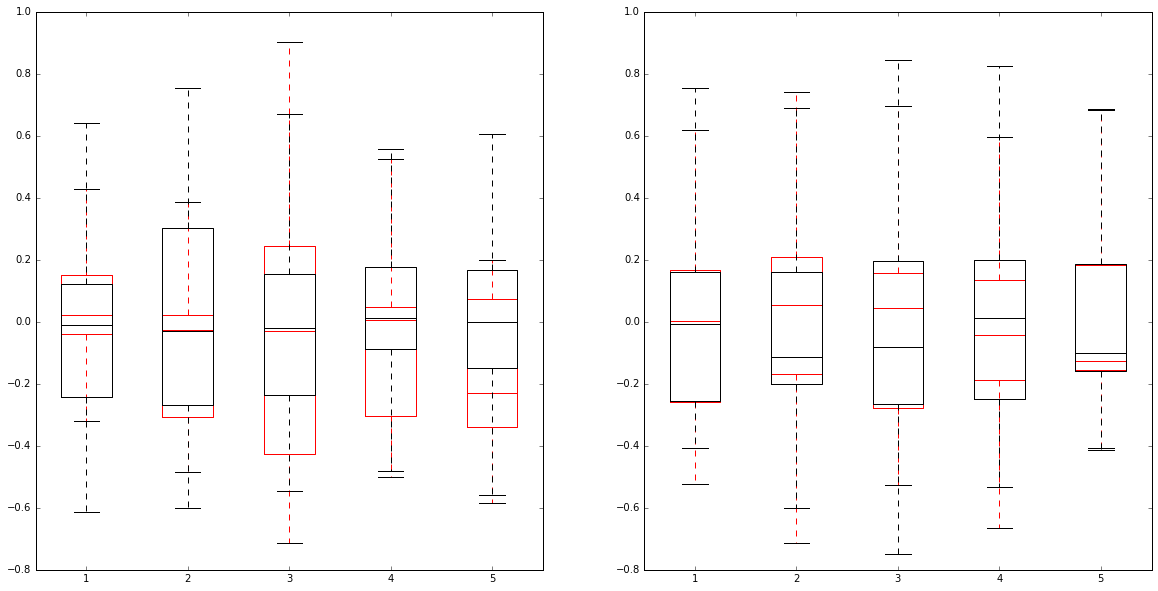

In [33]:
# per-move coherence construction

per_game_combs = [[[(exp, set(exp_ls) - {exp}) for exp_ls in game.values() for exp in exp_ls] 
                   for game in cond] for cond in game_lvl_dataset]



get_exp_len = lambda exp_tup: exp_tup[0][1] - exp_tup[0][0] + 1

per_game_combs_lens = [[[(exp[1], get_exp_len(exp), [get_exp_len(e) for e in other_exp_ls]) 
                         for exp, other_exp_ls in game] for game in cond] for cond in per_game_combs]


#print per_game_combs_lens

coh_metric = lambda e, prev_e: float(e - prev_e)/(e + prev_e)

coh_metric_over_ls = lambda e, e_ls: [coh_metric(e, other_e) for other_e in e_ls]

per_game_comb_coh_metrics = [[[(speaker, coh_metric_over_ls(exp, other_exps)) 
                               for speaker, exp, other_exps in game] for game in cond] for cond in per_game_combs_lens]


game_speaker_comb_metrics = [[([coh_ls for s, coh_ls in game if s == 'e-utts'], 
                               [coh_ls for s, coh_ls in game if s == 'p-utts']) 
                              for game in cond] for cond in per_game_comb_coh_metrics]



game_speaker_comb_metrics_avgs = [[([np.mean(e_m) for e_m in e_metrics], [np.mean(p_m) for p_m in p_metrics]) 
                                   for (e_metrics, p_metrics) in cond] for cond in game_speaker_comb_metrics]

filter_nan = lambda ls : filter(lambda x: not np.isnan(x), ls)

game_speaker_comb_metrics_avgs = [[(filter_nan(e_metrics), filter_nan(p_metrics)) 
                                   for (e_metrics, p_metrics) in cond] for cond in game_speaker_comb_metrics_avgs]

per_speaker_comb_vals = [list(zip(*cond)) for cond in game_speaker_comb_metrics_avgs]



game_speaker_comb_metrics_avgs = [[(np.mean(e_metrics), np.mean(p_metrics)) 
                                   for (e_metrics, p_metrics) in cond] for cond in game_speaker_comb_metrics_avgs]

per_speaker_comb_avgs = [list(zip(*cond)) for cond in game_speaker_comb_metrics_avgs]


ptt_e_mean_comb, ptt_p_mean_comb, ftt_e_mean_comb, ftt_p_mean_comb = [np.mean(speaker_ls) 
                                                                      for cond in per_speaker_comb_avgs 
                                                                      for speaker_ls in cond]

ptt_e_var_comb, ptt_p_var_comb, ftt_e_var_comb, ftt_p_var_comb = [np.var(speaker_ls) for cond in per_speaker_comb_avgs
                                                                      for speaker_ls in cond]


print 'GAME LEVEL:\n'
print 'COHERENCE:\n'
print 'PTT:'
print 'e-utts: ', ptt_e_mean_comb
print '\t variance: ', ptt_e_var_comb
print 'p-utts: ', ptt_p_mean_comb
print '\t variance: ', ptt_p_var_comb
print '\nFTT:'
print 'e-utts: ', ftt_e_mean_comb
print '\t variance: ', ftt_e_var_comb
print 'p-utts: ', ftt_p_mean_comb
print '\t variance: ', ftt_p_var_comb

print '\nALL:'
print 'e-utts: ', np.mean(per_speaker_comb_avgs[0][0]+per_speaker_comb_avgs[1][0])
print '\t variance: ', np.var(per_speaker_comb_avgs[0][0]+per_speaker_comb_avgs[1][0])
print 'p-utts: ', np.mean(per_speaker_comb_avgs[0][1]+per_speaker_comb_avgs[1][1])
print '\t variance: ', np.var(per_speaker_comb_avgs[0][1]+per_speaker_comb_avgs[1][1])


fig = plt.figure(figsize=[20, 10])
for i, cond in enumerate(per_speaker_comb_vals):
    first = True
    fig.add_subplot(int(str(12)+str(i+1)))
    for speaker in cond:        
        bp_A = plt.boxplot(speaker, 0, '')
        if first:
            plt.setp(bp_A['boxes'], color='red')
            plt.setp(bp_A['medians'], color='red')
            plt.setp(bp_A['whiskers'], color='red')
        else:
            plt.setp(bp_A['boxes'], color='black')
            plt.setp(bp_A['medians'], color='black')
            plt.setp(bp_A['whiskers'], color='black')
        first = False
plt.show()

In [34]:
num_succ = 0

global num_succ 


def get_previous(refexp, obj_refexps):
    '''
    Outputs the last referring expression used for that object by the other speaker
    :param refexp: referring expression tuple
    :param obj_refexps: list of referring expressions for that object
    :return:
    '''
    i = obj_refexps.index(refexp) - 1
    speaker = refexp[1]
    previous = 'HELLO'#'no_previous'
    while i >= 0:
        if obj_refexps[i][1] != speaker:
            get_previous.num_succ += 1
            previous = obj_refexps[i]
            break
        i =- 1
    return previous
get_previous.num_succ = 0

# per-move coherence construction

per_game_prevs = [[[(exp, get_previous(exp, exp_ls)) for exp_ls in sorted(game.values(), key=lambda tup: tup[0][0])
                    for exp in exp_ls] 
                   for game in cond] for cond in game_lvl_dataset]

print get_previous.num_succ

print sum([sum([sum([1 for prev_tup in game]) for game in cond]) for cond in per_game_prevs])

#print per_game_prevs

per_game_combs_lens = [[[(exp[1], get_exp_len(exp), [get_exp_len(e) for e in other_exp_ls]) 
                         for exp, other_exp_ls in game] for game in cond] for cond in per_game_combs]

get_exp_len = lambda exp_tup: exp_tup[0][1] - exp_tup[0][0] + 1

per_game_combs_lens = [[[(exp[1], get_exp_len(exp), [get_exp_len(e) for e in other_exp_ls]) 
                         for exp, other_exp_ls in game] for game in cond] for cond in per_game_combs]



886
4263


[[(96, 96), (94, 96)], [(132, 134), (130, 134)]]

[(0, 0), (1, 0), (1, 1), (2, 1), (3, 2), (3, 1), (4, 3), (5, 4), (6, 3)]
correlation:  (0.90492101437281325, 0.00079430829735013841)


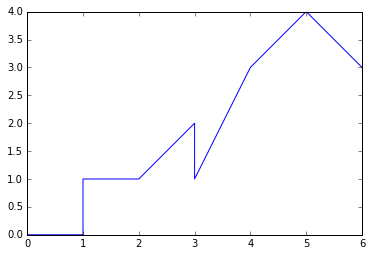

[(0, 0), (1, 0), (1, 1), (2, 1), (2, 0), (2, 2), (3, 2), (3, 1), (4, 3), (4, 2), (4, 1), (5, 2), (5, 4), (5, 3), (6, 4), (6, 5), (7, 4), (8, 5), (8, 4)]
correlation:  (0.89001817562405794, 3.3596821811812907e-07)


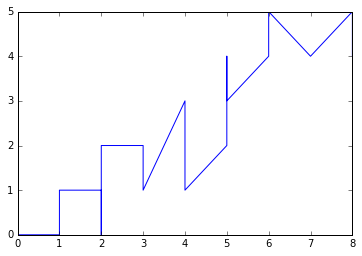

[(0, 0), (1, 0), (1, 1), (2, 1), (2, 0), (2, 2), (3, 2), (4, 3), (5, 2), (7, 5)]
correlation:  (0.89420809801229495, 0.00048145946887572086)


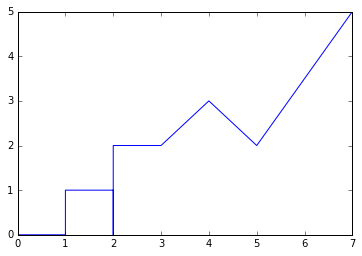

[(0, 0), (1, 0), (1, 1), (2, 1), (2, 0), (2, 2), (3, 3), (3, 1), (3, 2), (4, 3), (4, 2), (4, 1), (4, 4), (5, 4), (5, 3), (6, 3), (7, 3), (7, 4), (7, 5), (8, 4), (10, 6)]
correlation:  (0.87136615240074644, 2.7207370704160046e-07)


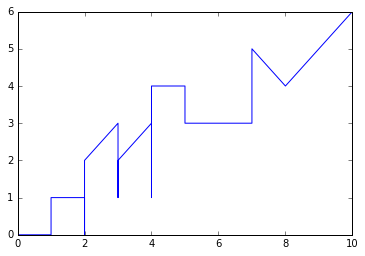

In [36]:
# decrease of length

get_exp_len = lambda exp_tup: exp_tup[0][1] - exp_tup[0][0] + 1

per_move_lens = [{move_span: sorted(set([(exp[1], get_exp_len(exp))
              for ref_obj_exp_ls in obj_dict.values() for exp in ref_obj_exp_ls]), key=lambda exp: exp[0][0]) for d in cond 
                  for move_span, obj_dict in d} for cond in move_lvl_dataset]

per_move_speaker_lens = [{move_span: ([exp[1] for exp in exp_ls if exp[0] == 'e-utts'],
                                     [exp[1] for exp in exp_ls if exp[0] == 'p-utts'])
                         for move_span, exp_ls in cond.iteritems()}
                          for cond in per_move_lens]


per_speaker_lists = [list(zip(*cond.values())) for cond in per_move_speaker_lens]


from collections import Counter


per_speaker_diffs = [[tuple([exp_len - move_ls[i+1] for i, exp_len in enumerate(move_ls) if i < len(move_ls) - 1] 
   for move_ls in speaker) for speaker in cond] for cond in per_speaker_lists]

per_speaker_bool_diffs = [[tuple([int(exp_len - move_ls[i+1] > 0) for i, exp_len in enumerate(move_ls) if i < len(move_ls) - 1] 
   for move_ls in speaker) for speaker in cond] for cond in per_speaker_lists]

per_speaker_merged_bool_diffs = [[[(len(move_ls), sum(move_ls)) for move_ls in speaker] for speaker in cond] for cond in per_speaker_bool_diffs]

per_speaker_bool_diff_counts = [[Counter(speaker) for speaker in cond] for cond in per_speaker_merged_bool_diffs]

per_speaker_decrease_counts = [[(sum(count for len_sum, count in speaker.iteritems() if len_sum[1] >= len_sum[0]/2) ,
                                 sum(speaker.values()))
                                 for speaker in cond] 
                                    for cond in per_speaker_bool_diff_counts]

print per_speaker_decrease_counts

#print per_speaker_bool_diff_counts

print

#print per_speaker_merged_bool_diffs

from scipy.stats import pearsonr

for cond in per_speaker_bool_diff_counts:
    for speaker in cond:
        print sorted(speaker.keys(), key=lambda tup: tup[0])
        lens, sums = list(zip(*sorted(speaker.keys(), key=lambda tup: tup[0])))
        print 'correlation: ', pearsonr(lens, sums)
        plt.plot(lens, sums)
        plt.show()